## 다람쥐, 쥐, 토끼의 COI 염기서열 140개 무작위 추출 후 aln으로 저장

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez
from Bio import SeqIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 30, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   

## 원본과 예측값 비교를 위한 시각화 

In [4]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
species = ['Rattus rattus', 'Mus musculus', 'Microtus fortis', 'Tamias sibiricus', 'Pteromys volans',
            'Sciurus vulgaris', 'Cricetulus barabensis', 'Myodes rutilus', 'Apodemus agrarius']

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    for id in Idlist:
        getFasta(id)

## creating MT932266.1.fasta...
## creating NC_012374.1.fasta...
## creating MN536017.1.fasta...


KeyboardInterrupt: 

In [3]:
getAln('all_coi.fasta')

/Users/kimjoonsu/muscle3.8.31_i86darwin64 -in all_coi.fasta -out all_coi.aln -clw


## 데이터 전처리 및 DataFrame 구성

* DataFrame의 Target 구성을 위해 종(species) 크롤링 

In [2]:
from Bio import SeqIO
from Bio import Entrez
from Bio import GenBank

Entrez.email = "nagabuti13@naver.com"

#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getOrganism(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    a = []
    for i in r.organism:
        if(i.isdigit() == True):
            break
        else:
            a.append(i)
    return ''.join(a[:-1])

* DataFrame의 열(feature) 구성을 위해 k-mer(k = 3)을 활용

In [3]:
#[220508_1659]CREATED Sequecne Alignment를 다룰 수 있는 모듈 호출
from Bio import AlignIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

alignment = AlignIO.read('all_coi.aln', 'clustal')

k = 3
dict = {}
df = pd.DataFrame()
#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #datatype['---'] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['target'] = 0

init(df)

#[220508_1738]CREATED 'all.aln' 안의 모든 개체의 염기서열을 k = 3인 kmers로 구분짓고 빈도를 사전에 저장
for i, record in enumerate(alignment):
    init(dict)
    #[220509_1517]NOTED getOrganism() 호출
    dict['target'] = getOrganism(record.id)
    index = 0
    if(len(record.seq) >= k):
        while(index + k <= 1546):
            mer = record.seq[index:index + k]
            if(mer.find('-') != -1):
                #dict['---'] += 1
                index += 1
                continue
            #[220513_1810]CREATED kmer 문자열을 base_dict의 values로 교체
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
                
            dict[mer] += 1
            index += 1
    df.loc[i] = dict
    
#[220508_2232]NOTED 총 문자열 길이를 L이라 하면, kmers의 개수: L - k + 1 ex) 1542 - 3 + 1 = 1540개
#[220513_1623]NOTED 1542 -> 17377(하나의 시퀀스의 실제 길이: 약 600bp이지만 MSA의 경우 '-'로 인해 길어져 보인다.)

In [4]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,Cricetulus barabensi
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,Cricetulus barabensi
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,Cricetulus barabensi
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,Myodes rutilu
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,Microtus forti
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,Pteromys volan
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,Pteromys volan
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,Pteromys volan
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,Pteromys volan


## 1. 점수 매기기

In [5]:
arr = np.zeros((144, 144), dtype = 'int32')
scores = pd.DataFrame(arr)
scores

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
for i in df.index:
    for j in df.index:
        if(j == i):
            continue
        else:
            for k in df.columns[:-1]:
                scores.loc[i, j] += abs(df.loc[i, k] - df.loc[j, k])
                #[220719_1233]NOTED 데이터프레임의 원소를 수정할 때는 df.loc[j, 'score']을 사용해야 한다.    

In [51]:
""" for i in df.index:
    for j in df.index:
        if(j == i):
            continue
        else:
            for k in df.columns[:-1]:
                if(df.loc[i, k] == df.loc[j, k]):
                    scores.loc[i, j] += 1 """

In [7]:
# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

scores #[220719_1334]NOTED 대칭행렬

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143
0,0,92,92,232,219,215,215,212,215,901,901,898,217,901,234,222,908,908,901,916,226,916,219,219,217,217,217,217,219,219,217,916,221,226,916,227,227,229,229,908,749,916,176,199,160,162,160,162,169,163,165,162,161,165,166,161,165,166,166,169,162,159,164,163,163,169,165,165,165,163,163,163,171,161,161,161,155,157,159,157,157,161,161,161,161,161,156,156,156,169,147,185,183,158,160,164,164,158,158,158,160,158,158,158,158,158,158,156,156,156,156,156,179,179,165,165,169,169,165,163,154,158,152,193,193,193,193,152,150,148,148,148,148,148,191,154,154,154,152,197,201,199,193,203
1,92,0,20,198,187,187,187,186,187,885,885,882,195,885,214,208,892,892,883,898,212,898,207,207,205,205,205,205,207,207,203,898,211,216,898,213,213,217,217,892,731,900,188,209,166,168,166,172,177,173,175,174,177,179,178,175,179,178,178,185,176,175,176,175,175,175,169,169,169,169,169,169,177,163,167,167,163,165,167,167,167,169,169,169,169,169,184,184,184,195,161,181,185,154,156,166,166,156,156,156,156,162,154,154,154,154,154,150,150,150,150,150,179,181,173,173,177,175,173,171,156,170,156,201,201,201,201,156,154,152,152,152,152,152,199,166,166,166,140,193,197,199,191,199
2,92,20,0,196,193,193,193,188,189,885,885,882,197,885,212,206,890,890,879,894,210,896,205,205,203,203,203,203,205,205,203,896,209,212,896,211,211,215,215,890,729,898,186,213,162,164,162,176,179,177,179,178,181,183,182,179,183,182,182,187,178,177,178,177,177,179,169,169,169,171,171,171,179,165,169,169,165,165,165,171,171,169,169,169,169,171,180,180,180,191,165,179,183,152,156,162,162,152,152,152,154,158,152,152,152,152,152,148,148,148,148,148,179,181,169,169,173,171,169,167,162,170,160,203,203,203,203,160,158,156,156,156,156,156,201,162,162,162,142,195,199,201,191,201
3,232,198,196,0,153,151,151,154,149,887,887,884,155,887,188,190,892,892,881,896,186,898,187,187,189,189,189,189,185,185,191,898,185,186,898,189,189,189,189,890,731,900,216,231,202,202,210,208,207,207,209,212,207,207,212,213,213,212,212,209,210,205,210,209,209,207,209,209,211,211,211,211,223,211,213,213,215,217,219,223,223,213,213,213,213,213,198,198,198,211,209,235,239,218,220,224,224,226,226,226,226,222,222,222,222,222,222,218,216,216,216,216,233,239,211,211,215,211,211,207,208,220,210,221,221,221,221,210,212,210,210,210,210,210,221,220,220,220,218,227,225,237,229,235
4,219,187,193,153,0,18,18,23,20,874,874,871,26,874,161,153,881,881,876,891,159,891,160,160,162,162,162,162,162,162,164,891,162,165,891,158,158,160,160,881,724,891,209,258,217,217,219,207,212,212,210,215,212,218,213,216,214,213,213,210,209,204,205,204,204,166,166,166,164,174,174,174,178,172,172,172,178,174,174,176,176,170,170,170,170,170,201,201,201,206,224,254,258,235,239,241,241,247,247,247,243,241,241,241,241,241,241,237,235,235,235,235,248,254,222,222,228,226,220,218,211,215,213,238,238,238,238,213,215,213,213,213,213,213,234,237,237,237,229,244,248,260,248,258
5,215,187,193,151,18,0,0,25,22,874,874,871,30,874,159,153,881,881,874,891,155,891,156,156,158,158,158,158,158,158,160,891,158,161,891,158,158,156,156,879,722,889,209,254,215,215,217,207,212,212,210,215,208,214,213,216,214,213,213,206,209,204,205,204,204,168,170,170,168,178,178,178,180,174,174,174,180,176,174,178,178,174,174,174,174,172,201,201,201,208,220,256,260,237,241,245,245,249,249,249,245,243,243,243,243,243,243,239,237,237,237,237,250,256,220,220,226,222,218,218,213,219,215,238,238,238,238,215,217,215,215,215,215,215,234,237,237,237,231,244,248,262,250,260
6,215,187,193,151,18,0,0,25,22,874,874,871,30,874,159,153,881,881,874,891,155,891,156,156,158,

## 2. Top 5 추출

In [11]:
top_5_sp = []
scores.iloc[14].nsmallest(10, keep = 'all')


14     0
15    26
20    30
32    39
33    42
30    45
37    45
38    45
24    49
25    49
26    49
27    49
Name: 14, dtype: int64

In [8]:
df[df['target'] == 'Myodes rutilu'].index
#[220719_1358]NOTED 상위 5개로 설정할 시 Cricetulus barabensi의 경우 개체가 3개이기 때문에 다른 종 두 개체가 변이를 제거하는데 쓰일 가능성이 있음 => 상위 5 -> 3개로 수정하는 것이 좋을 수도 있음

Int64Index([ 3, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
            30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
           dtype='int64')

## 머신러닝으로 9개 종 군집화

In [5]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[1 1 1 4 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5 5 5 5 5 5 5 5 5]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,1
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,1
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,1
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,4
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,2


### K-means

* elbow method

c:\Users\nagab\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


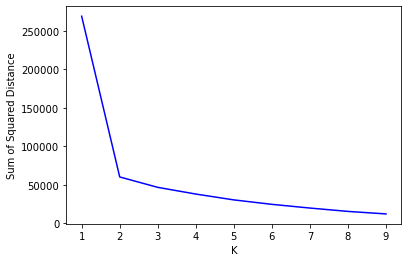

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 10)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 500)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220801_1511]CREATED k = 2 ~ 3일 때가 최적 but 실제는 9이므로 신뢰도 낮음

In [32]:

df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,1
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,1
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,1
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,4
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,5
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,5
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,5
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,5


* silhouette

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 10)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=500)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    sil_tot = silhouette_score(df.iloc[:, :-2], df['cluster'])
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    print('전체 실루엣 계수 평균: {0:.3f}, 군집 별 실루엣 계수 평균: {1}'.format(sil_tot, sil_clu))
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)

전체 실루엣 계수 평균: 0.788, 군집 별 실루엣 계수 평균: cluster
0    0.787198
1    0.800298
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.323, 군집 별 실루엣 계수 평균: cluster
0    0.268110
1    0.795115
2    0.271053
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.370, 군집 별 실루엣 계수 평균: cluster
0    0.544912
1    0.789915
2    0.237726
3    0.331563
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.460, 군집 별 실루엣 계수 평균: cluster
0    0.788814
1    0.288004
2    0.370434
3    0.676094
4    0.487535
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.515, 군집 별 실루엣 계수 평균: cluster
0    0.322015
1    0.788814
2    0.672717
3    0.652043
4    0.357591
5    0.477381
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.512, 군집 별 실루엣 계수 평균: cluster
0    0.502760
1    0.356037
2    0.663115
3    0.473390
4    0.363761
5    0.938369
6    0.825223
Name: sil_sam, dtype: float64
---------------
전체 실루엣 계수 평균: 0.571, 군집 별 실루엣 계수 평균: cluster
0    0.338629
1    0.663115
2  

In [8]:
df.groupby(['target', 'cluster'])['AAA'].count()

target  cluster
0       2          21
1       4           3
2       6           4
        8           6
3       0           4
4       1          10
        3          18
        8           1
5       4           4
        7           5
6       0          23
7       4          10
        7           5
8       5          19
        7          11
Name: AAA, dtype: int64

* PCA(차원 축소)

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca_transformed = pca.fit_transform(df.iloc[:, :-1])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCG,TCC,TCT,TTA,TTG,TTC,TTT,target,pca_x,pca_y
0,7,2,12,21,6,8,15,7,13,2,...,4,8,16,22,11,13,20,1,-10.082539,-5.255827
1,7,0,13,21,6,9,14,6,12,4,...,6,13,18,23,8,19,16,1,-8.180600,-5.978270
2,7,0,13,20,6,10,14,6,12,4,...,6,13,17,23,8,18,16,1,-7.429091,-6.109571
3,6,2,18,16,4,11,15,6,15,5,...,4,17,16,15,7,18,9,4,-8.736398,6.519824
4,5,2,17,18,4,9,14,8,13,4,...,10,15,15,12,5,19,10,2,-5.948062,9.038580


* <원본>

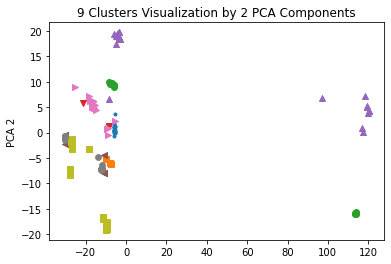

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

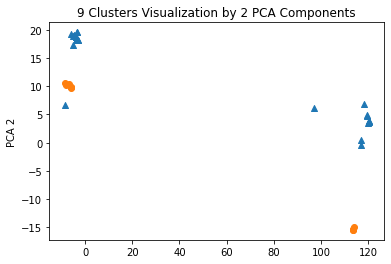

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x = df.loc[df[df['target'] == 4].index, 'pca_x'], y = df.loc[df[df['target'] == 4].index, 'pca_y'], marker = '^')
plt.scatter(x = df.loc[df[df['target'] == 2].index, 'pca_x'], y = df.loc[df[df['target'] == 2].index, 'pca_y'], marker = 'o')

plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

* <예측값>

In [20]:
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['kmeans_cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()

KeyError: 'kmeans_cluster'

In [12]:
df.iloc[:,:-4]

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,---
0,7,2,12,21,6,8,15,7,13,2,...,6,11,4,8,16,22,11,13,20,907
1,7,0,13,21,6,9,14,6,12,4,...,4,9,6,13,18,23,8,19,16,891
2,7,0,13,20,6,10,14,6,12,4,...,4,10,6,13,17,23,8,18,16,891
3,6,2,18,16,4,11,15,6,15,5,...,6,15,4,17,16,15,7,18,9,891
4,5,2,17,18,4,9,14,8,13,4,...,5,13,10,15,15,12,5,19,10,880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,4,3,9,16,3,8,15,6,7,3,...,7,8,2,6,14,17,8,9,23,1032
140,4,3,9,16,3,8,15,6,7,3,...,9,8,2,6,14,17,8,9,23,1032
141,4,3,9,16,4,8,15,6,7,3,...,9,7,2,6,13,19,8,9,24,1032
142,4,3,9,16,4,8,16,5,7,3,...,9,7,2,6,14,18,8,9,22,1032
